In [58]:
from pathlib import Path

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator, MACCSkeys

from sklearn.cluster import DBSCAN
from joblib import Parallel, delayed
from tqdm import tqdm

import umap
import matplotlib.pyplot as plt

In [43]:
HERE = Path.cwd()
DATA = HERE / "data"

In [44]:
def check_number_of_labels(n_labels, n_samples):
    if not 1 < n_labels < n_samples:
        raise ValueError("Number of labels is %d. Valid values are 2"
                         "to n_samples - 1 (inclusive)" % n_labels)


def FingerprintFromSmiles(smiles, method='morgan'):
    """Converts SMILES to Fingerprint"""

    if method == "rdkit":
        rdk_fpg = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        return rdk_fpg.GetFingerprint(Chem.MolFromSmiles(smiles))
    elif method == "morgan":
        mfp_fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        return mfp_fpg.GetFingerprint(Chem.MolFromSmiles(smiles))
    elif method == "maccs":
        return MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles))
    else:
        return "invalid method: use rdkit or morgan"

In [45]:
zinc_data_f = pd.read_csv(DATA / "filtered_zinc_data.csv")
# data_r = pd.read_csv("")

print(zinc_data_f.shape)
zinc_data_f.head()

(486318, 6)


,smiles,zinc_id,inchikey,mwt,logp,reactive
0,Cc1cc(C(=O)O)nn1C(C)(C)C,128082,FCFGJNOOQYQMKY-UHFFFAOYSA-N,182.223,1.645,0
1,Cc1cc(C=O)oc1C,153224,JPTPEPVCVXGNJM-UHFFFAOYSA-N,124.139,1.709,0
2,Oc1nc2ccc(Cl)cc2nc1O,336490,RNOLFZACEWWIHP-UHFFFAOYSA-N,196.593,1.694,0
3,CC(C)[C@@H]1C(=O)C[C@@H](C)CN1C,1296142,ALCOISCHVBFFNS-PSASIEDQSA-N,169.268,1.552,0
4,COc1cc(N(C)C)ccc1C=O,1583074,HGDRXADJVGVGBC-UHFFFAOYSA-N,179.219,1.574,0


Calculate circular **Morgan fingerprints** for molecules and add those values to a DataFrame as a separate column named morgan_fp.

In [46]:
zinc_data_f["morgan_fp"] = [FingerprintFromSmiles(smiles, method="morgan") for smiles in tqdm(zinc_data_f["smiles"], desc="Generating Morgan fingerprints for zinc_data")]

print(zinc_data_f.shape)
zinc_data_f.head()

Generating Morgan fingerprints for zinc_data: 100%|██████████| 486318/486318 [01:01<00:00, 7893.97it/s]

(486318, 7)


,smiles,zinc_id,inchikey,mwt,logp,reactive,morgan_fp
0,Cc1cc(C(=O)O)nn1C(C)(C)C,128082,FCFGJNOOQYQMKY-UHFFFAOYSA-N,182.223,1.645,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1cc(C=O)oc1C,153224,JPTPEPVCVXGNJM-UHFFFAOYSA-N,124.139,1.709,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Oc1nc2ccc(Cl)cc2nc1O,336490,RNOLFZACEWWIHP-UHFFFAOYSA-N,196.593,1.694,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CC(C)[C@@H]1C(=O)C[C@@H](C)CN1C,1296142,ALCOISCHVBFFNS-PSASIEDQSA-N,169.268,1.552,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc(N(C)C)ccc1C=O,1583074,HGDRXADJVGVGBC-UHFFFAOYSA-N,179.219,1.574,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Convert morgan fingerprints of type ExplicitBitVect to NumPy Array.

In [48]:
# Fingerprints are a Series of ExplicitBitVect objects
fps = zinc_data_f["morgan_fp"]

# Convert to a 2D Numpy array
arr = []
for fp in tqdm(fps, desc="Converting to NumpyArray"):
    fp_arr = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, fp_arr)
    arr.append(fp_arr)

X = np.array(arr)
print(X.shape)

100%|██████████| 486318/486318 [00:28<00:00, 16848.31it/s]


(486318, 2048)


Let's use 10.000 items for memory concerns.

In [53]:
X_10_000 = X[:10000].copy()

Before running DBSCAN apply dimensionality reduction using UMAP.

In [54]:
# Step 1: Dimensionality reduction using UMAP
reducer = umap.UMAP(
    n_neighbors=15,     # balance local vs global structure
    n_components=2,     # for visualization (or 10-50 for clustering)
    metric='jaccard'
)

# Run UMAP
with tqdm(desc="Running Umap") as pbar:
    X_umap = reducer.fit_transform(X_10_000)
    pbar.update()

Running Umap: 0it [00:00, ?it/s]C:\Users\hrach\Desktop\Denovo Sciences\Hamlet Meetings\Task2_Compound_Clustering\.venv\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
Running Umap: 1it [00:08,  8.91s/it]


Run DBSCAN on Converted fingerprints.

In [56]:
# Step 2: DBSCAN clustering on reduced data
db = DBSCAN(eps=0.5,min_samples=5)
with tqdm(desc="Running DBSCAN") as pbar:
    db.fit(X_umap)
    pbar.update()

zinc_data_f_10_000 = zinc_data_f[:10000].copy()
zinc_data_f_10_000["cluster"] = db.labels_

Running DBSCAN: 1it [00:00,  8.10it/s]


Plot the results (2D)

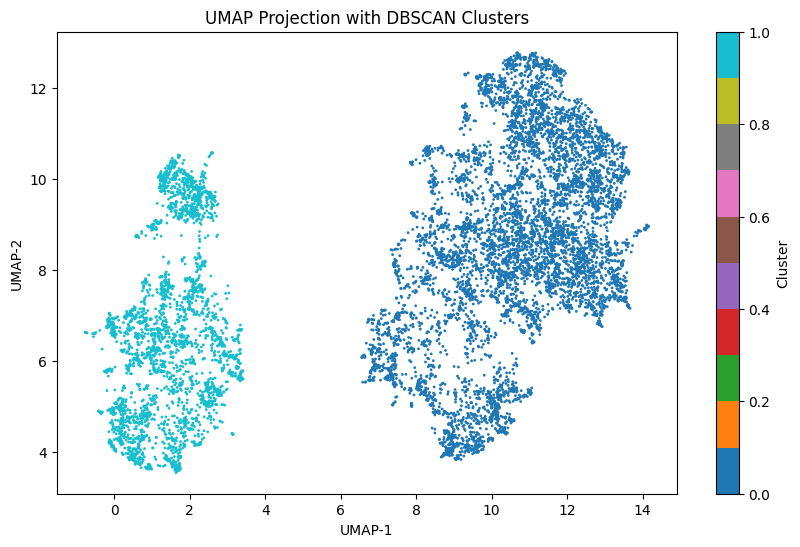

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=db.labels_, cmap="tab10", s=1)
plt.title("UMAP Projection with DBSCAN Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster")
plt.show()